<a href="https://colab.research.google.com/github/kra268/ChemCoder/blob/main/NNLipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install PyTDC deepchem rdkit==2023.03.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import rdkit
rdkit.__version__

'2023.03.1'

In [3]:
import numpy as np
import pandas as pd
import deepchem as dc  # Featurization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tdc.single_pred import ADME
from rdkit.Chem import PandasTools, AllChem, Descriptors, AddHs

In [4]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
split = data.get_split('scaffold')

Downloading...
100%|██████████| 298k/298k [00:00<00:00, 1.15MiB/s]
Loading...
Done!
100%|██████████| 4200/4200 [00:01<00:00, 2185.28it/s]


In [5]:
split['train']

,Drug_ID,Drug,Y
0,CHEMBL1951894,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21
1,CHEMBL1951893,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,2.67
2,CHEMBL197536,O=c1cc(N2CCOCC2)oc2cc(O)ccc12,1.00
3,CHEMBL1807852,C[C@H]1O[C@@H](n2cnc3c(N)nc(OC4CC5CC5C4)nc32)[...,1.66
4,CHEMBL23,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,1.99
...,...,...,...
2935,CHEMBL181326,O=C(NCC(=O)N(CCO)c1ccccc1)c1cc2cc(Cl)ccc2[nH]1,3.37
2936,CHEMBL1688458,O=C(O)CCc1ccc(OCc2cccc(Oc3ccccc3)c2)cc1,2.47
2937,CHEMBL1682949,CC[C@H](NC(=O)c1c([S+](C)[O-])c(-c2cccs2)nc2cc...,3.56
2938,CHEMBL366947,CC(C)(C)OC(=O)c1ncn2c1[C@@H]1CCCN1C(=O)c1c(Br)...,2.48


In [6]:
train = split['train']
test = split['test']
valid = split['valid']

In [7]:
train.shape

(2940, 3)

In [8]:
test.shape

(840, 3)

In [9]:
valid.shape

(420, 3)

In [10]:
PandasTools.AddMoleculeColumnToFrame(train, 'Drug', 'Molecule')

In [11]:
train.sample(3)

,Drug_ID,Drug,Y,Molecule
978,CHEMBL2178372,Cc1nc(C)c(-c2ccc(C34CCC(CC(=O)O)(CC3)CC4)cc2)n...,1.60,<rdkit.Chem.rdchem.Mol object at 0x7f89ac917220>
2771,CHEMBL1557436,CN(C)c1ccnc2sc(C(=O)NCc3ccccc3)c(N)c12,3.62,<rdkit.Chem.rdchem.Mol object at 0x7f89ac91c900>
1970,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,3.82,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8de730>


In [12]:
PandasTools.AddMoleculeColumnToFrame(test, 'Drug', 'Molecule')
PandasTools.AddMoleculeColumnToFrame(valid, 'Drug', 'Molecule')

In [13]:
test.sample(3)

,Drug_ID,Drug,Y,Molecule
118,CHEMBL1934417,COCCC(C)n1nc(C)c(C(=O)N[C@@H](C)C(C)(C)C)c1NS(...,0.78,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8a8ac0>
100,CHEMBL1213085,Cc1ccccc1-n1c(Cn2nc(-c3ccc(O)c(F)c3)c3c(N)ncnc...,3.55,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8a82e0>
807,CHEMBL2171013,Cc1ccc(S(=O)(=O)N(C)C(=O)N2CCC(N3CCC(Oc4ccc(Cl...,4.49,<rdkit.Chem.rdchem.Mol object at 0x7f89ac827a70>


In [14]:
valid.sample(3)

,Drug_ID,Drug,Y,Molecule
264,CHEMBL1904754,Cc1nc2ncnn2c(O)c1CCOC(=O)c1ccccc1F,0.99,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8c80b0>
55,CHEMBL2178948,Cc1nc(C)c(-c2ccc3c(c2)CC[C@]32CC[C@H](C(=O)O)C...,1.30,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8fa490>
123,CHEMBL2335878,CN(C)CCNC(=O)c1ccc(Nc2ncc3cc(-c4ccncc4)ccc3n2)cc1,2.29,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8e8270>


In [15]:
train['Molecule'] = train.Molecule.apply(AddHs)

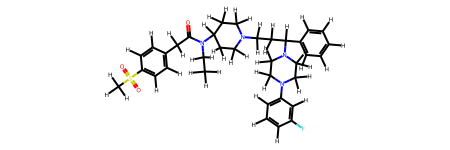

In [16]:
train.Molecule[0]

In [17]:
test['Molecule'] = test.Molecule.apply(AddHs)
valid['Molecule'] = valid.Molecule.apply(AddHs)

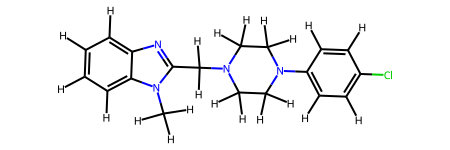

In [18]:
test.Molecule[0]

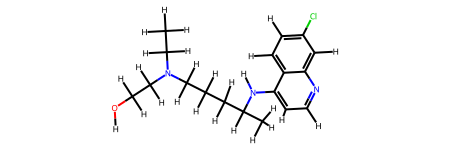

In [19]:
valid.Molecule[0]

In [20]:
des_keys = Descriptors.CalcMolDescriptors(valid.Molecule[0]).keys()

In [21]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [22]:
# Create a featurizer object
featurizer = dc.feat.RDKitDescriptors()

In [23]:
train['descript'] = train.Molecule.apply(featurizer.featurize)

In [24]:
train.head()

,Drug_ID,Drug,Y,Molecule,descript
0,CHEMBL1951894,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,3.21,<rdkit.Chem.rdchem.Mol object at 0x7f89ac89c970>,"[[15.424770250248978, 15.424770250248978, 0.92..."
1,CHEMBL1951893,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,2.67,<rdkit.Chem.rdchem.Mol object at 0x7f89ac89cba0>,"[[15.023139174262797, 15.023139174262797, 0.80..."
2,CHEMBL197536,O=c1cc(N2CCOCC2)oc2cc(O)ccc12,1.00,<rdkit.Chem.rdchem.Mol object at 0x7f89ac89ccf0>,"[[12.749214143990928, 12.749214143990928, 0.24..."
3,CHEMBL1807852,C[C@H]1O[C@@H](n2cnc3c(N)nc(OC4CC5CC5C4)nc32)[...,1.66,<rdkit.Chem.rdchem.Mol object at 0x7f89ac89ce40>,"[[8.911682991206124, 8.911682991206124, 0.0155..."
4,CHEMBL23,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,1.99,<rdkit.Chem.rdchem.Mol object at 0x7f89ac89cdd0>,"[[14.87330024372773, 14.87330024372773, 0.5636..."


In [25]:
type(train.descript[0])

numpy.ndarray

In [26]:
# Write for test and valid
test['descript'] = test.Molecule.apply(featurizer.featurize)
valid['descript'] = valid.Molecule.apply(featurizer.featurize)

In [27]:
train['descript'] = train['descript'].apply(lambda x: list(x[0]))

In [28]:
# Write for test and valid
test['descript'] = test['descript'].apply(lambda x: list(x[0]))
valid['descript'] = valid['descript'].apply(lambda x: list(x[0]))

In [29]:
test.sample(1)

,Drug_ID,Drug,Y,Molecule,descript
679,CHEMBL1682972,CC[C@H](NC(=O)c1c([S+](C)[O-])c(-c2ccccc2)nc2c...,2.2,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8c0120>,"[14.82501831905601, 14.82501831905601, 0.86356..."


In [30]:
valid.sample(1)

,Drug_ID,Drug,Y,Molecule,descript
244,CHEMBL408194,COC1=CC(c2cc3ccccc3[nH]2)=N/C1=C\c1[nH]c(C)cc1C,2.55,<rdkit.Chem.rdchem.Mol object at 0x7f89ac8a9b60>,"[8.729889560762576, 8.729889560762576, 0.01205..."


In [31]:
# Write a function that separates out each descriptors into different columns
def get_des(data_set):
  for idx, mol in enumerate(data_set.Molecule):
    all_des = Descriptors.CalcMolDescriptors(mol)
    for des in des_keys:
      data_set.loc[idx,des] = all_des[des]

In [32]:
get_des(train)
get_des(test)
get_des(valid)

In [33]:
train.sample(1)

,Drug_ID,Drug,Y,Molecule,descript,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
2931,CHEMBL1312643,O=S(=O)(Cc1cc(N2CCOCC2)nc(-c2ccccn2)n1)c1ccccc1,1.34,<rdkit.Chem.rdchem.Mol object at 0x7f89ac76da10>,"[13.854261693109542, 13.854261693109542, 0.431...",13.854262,13.854262,0.431114,-5.945461,0.654299,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# A function to drop all the NULL values
# NOTE: RUN THIS ONLY ONCE! 
def drop_nulls(df):
    null_idxs = df[df.isnull().any(axis=1)].index.tolist()
    for idx in null_idxs:
        print('Dropping datapoints with NULL data')
        df = df.drop([idx])
        print(f'Index {idx} was dropped')

    return df

In [35]:
train = drop_nulls(train)
test = drop_nulls(test)
valid = drop_nulls(valid)

Dropping datapoints with NULL data
Index 560 was dropped


In [36]:
train.shape

(2939, 214)

In [37]:
valid[valid.isnull().any(axis=1)]

,Drug_ID,Drug,Y,Molecule,descript,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [38]:
train[train.isnull().any(axis=1)]

,Drug_ID,Drug,Y,Molecule,descript,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [46]:
fing_featurizer = dc.feat.CircularFingerprint(size=1024, radius=3) 

In [47]:
train['FingerP'] = train.Molecule.apply(fing_featurizer.featurize)

In [48]:
train.sample(3)

,Drug_ID,Drug,Y,Molecule,descript,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,FingerP
750,CHEMBL437526,CCO[C@@H]1OC(=O)C[C@@H]1NC(=O)[C@@H]1CCCN2C(=O...,1.16,<rdkit.Chem.rdchem.Mol object at 0x7f89ac731770>,"[15.100688446037019, 15.100688446037019, 1.014...",15.100688,15.100688,1.014278,-5.352895,0.525027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
459,CHEMBL467803,Cc1oc(S(C)(=O)=O)cc1-c1c2c(=O)n(C)c(=O)n(CC3CC...,4.48,<rdkit.Chem.rdchem.Mol object at 0x7f89ac729700>,"[14.544211552127992, 14.544211552127992, 0.048...",14.544212,14.544212,0.048566,-5.996539,0.316824,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2858,CHEMBL2023474,CCn1cc(NC(=O)Cc2ccc(Oc3ccnc4cc(F)ccc34)cc2OC)cn1,3.93,<rdkit.Chem.rdchem.Mol object at 0x7f89ac76b990>,"[14.452242285237906, 14.452242285237906, 0.159...",14.452242,14.452242,0.159969,-3.890890,0.473790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [49]:
train.FingerP

0       [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1       [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4       [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
                              ...                        
2935    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2936    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2937    [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2938    [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
2939    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: FingerP, Length: 2939, dtype: object

In [50]:
train['FingerP'] = train.FingerP.apply(lambda x: list(x[0]))

In [51]:
train.FingerP

0       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
                              ...                        
2935    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2936    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2937    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2938    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
2939    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: FingerP, Length: 2939, dtype: object

In [52]:
test['FingerP'] = test.Molecule.apply(fing_featurizer.featurize)
valid['FingerP'] = valid.Molecule.apply(fing_featurizer.featurize)

In [53]:
test['FingerP'] = test.FingerP.apply(lambda x: list(x[0]))
valid['FingerP'] = valid.FingerP.apply(lambda x: list(x[0]))

In [56]:
fea = train.descript[0] + train.FingerP[0]
len(fea)

1233

In [57]:
train['features'] = train['descript'] + train['FingerP']
test['features'] = test['descript'] + test['FingerP']
valid['features'] = valid['descript'] + valid['FingerP']

In [58]:
# Now let's set the target values for our data
y_train = train.Y
y_test = test.Y
y_valid = valid.Y

In [59]:
print(y_valid.shape)
print(valid.shape)

(420,)
(420, 216)


In [60]:
# Let's build a Neural Network! 

In [61]:
from sklearn.neural_network import MLPRegressor

In [62]:
NNmodel = MLPRegressor(hidden_layer_sizes=(500, 500,), max_iter=5000) # Two hidden layers with 500 nodes each

In [63]:
NNmodel.fit(train['features'].values.tolist(), y_train.values.tolist())

MLPRegressor(hidden_layer_sizes=(500, 500), max_iter=5000)

In [64]:
pred_test = NNmodel.predict(test['features'].values.tolist())

In [65]:
pred_test

array([ 3.43633196,  2.57944843,  3.62809152,  1.95400942,  3.84559744,
        3.78828414,  3.13524321,  1.80778778,  1.57452122,  1.04461643,
        1.35379464,  3.11595493,  2.59550085,  2.86549507,  2.59447388,
        2.62092181,  1.05022223,  2.43197857,  2.33522298,  3.91944021,
        2.98046652,  4.52743233,  2.627778  ,  2.46315436,  2.73736356,
        4.07008755, -0.03083436,  0.19507402,  1.77930576,  1.58167647,
       -0.06357676,  2.57587738,  2.18563443,  3.33890085,  2.30323656,
        2.15349913,  2.61748647,  3.94047142,  2.04969563,  1.71278093,
        3.32527924,  1.74388587,  1.86296491,  1.24256823,  3.24222544,
        3.17133199,  4.01386954,  3.28906451,  3.06674739,  2.07419534,
        0.55353277,  0.32176619,  0.44682397,  3.68593862,  3.64356621,
        3.27702909,  3.68203928,  0.93306376,  4.06541191,  2.00435574,
        1.20667103,  1.74868016,  3.1490891 ,  1.80635478,  0.29505926,
        2.94185411,  2.52944821,  2.51092195,  3.13563186,  2.52

In [66]:
import matplotlib.pyplot as plt

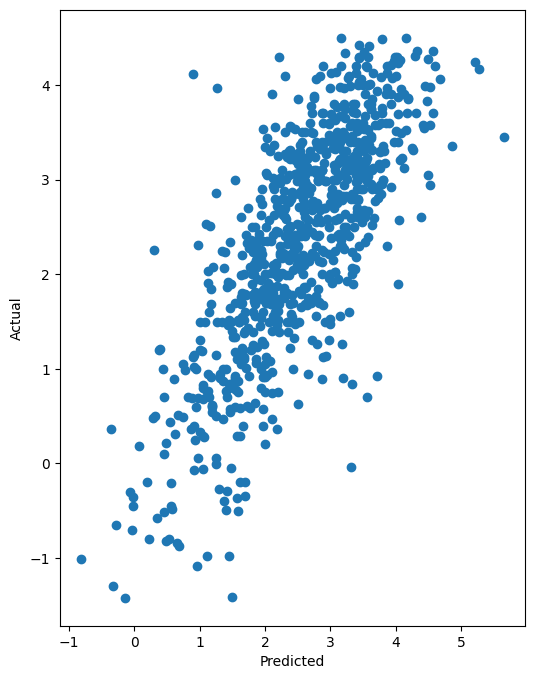

In [67]:
 plt.figure(figsize=(6,8))
 plt.scatter(pred_test, y_test)
 plt.xlabel('Predicted')
 plt.ylabel('Actual')
 plt.show()

In [68]:
mse = mean_squared_error(y_test, pred_test)

In [69]:
mse

0.6171031275453881

In [70]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, pred_test)
mae

0.6070237179183059